In [1]:
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import pandas as pd

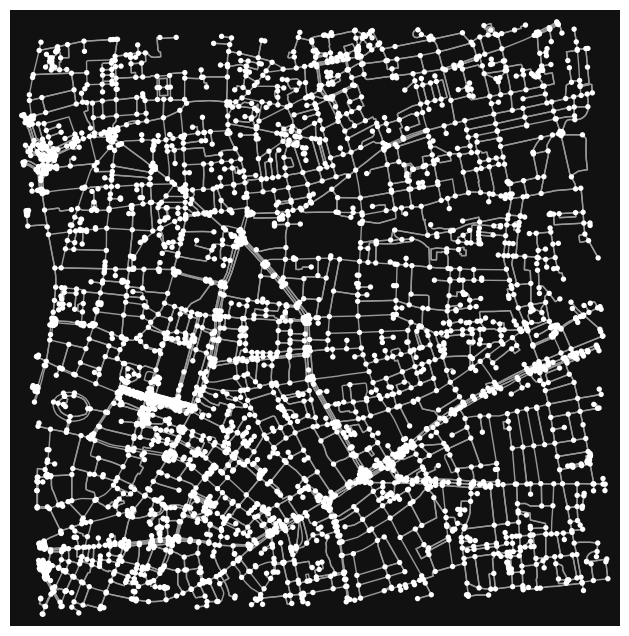

In [2]:
#Set geographic data acquisition parameters
# location_name = "Whitechapel, London, UK"

radius = 2000  # 2000m radius
# Set latitude and longitude coordinates
latitude =  51.5203 # Spitalfields
longitude = -0.0740

# Get street network data using latitude and longitude coordinates
graph = ox.graph_from_point((latitude, longitude), dist=1000, network_type='all')

# Draw geographic data
ox.plot_graph(ox.project_graph(graph))
plt.show()


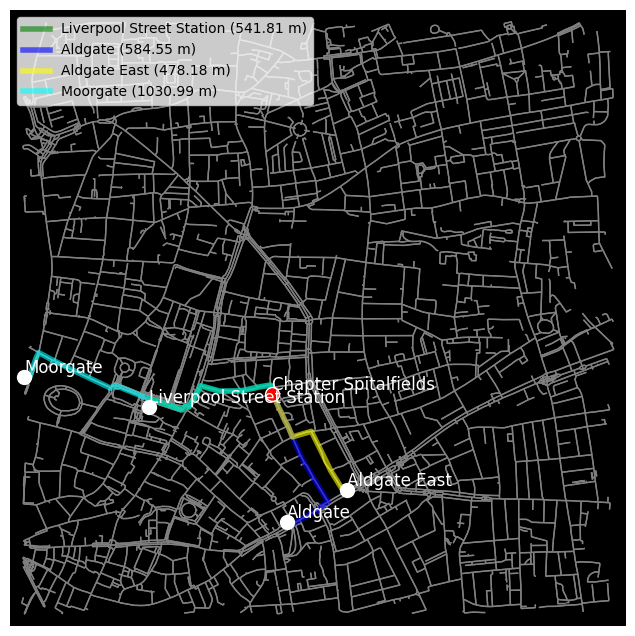

In [6]:
#Set geographic data acquisition parameters
latitude = 51.5203 # Latitude of Spitalfields
longitude = -0.0740 # longitude of Spitalfields
radius = 1000 # Radius of 1000 meters

# Get street network data using latitude and longitude coordinates
graph = ox.graph_from_point((latitude, longitude), dist=radius, network_type='walk')

# Approximate location of metro station and apartment

locations = {
    'Chapter Spitalfields': (51.517842320598405, -0.076822759558025),
    'Liverpool Street Station': (51.5175, -0.0823),
    'Aldgate': (51.5143, -0.0755),
    'Aldgate East': (51.5154, -0.0726),
    'Moorgate': (51.518596727731236, -0.08890437305161719),
}

graph_proj = ox.project_graph(graph)

location_nodes = {}

# Use ox.nearest_nodes to get the nearest nodes for each location
for location, (lat, lon) in locations.items():
    node = ox.nearest_nodes(graph, lon, lat)
    location_nodes[location] = node

# draw map
fig, ax = ox.plot_graph(graph, bgcolor='k', edge_color='gray', node_size=0, show=False, close=False)

# color list
colors = ['red', 'green', 'blue', 'yellow', 'cyan']

# # Calculate each path and add them to the path list
# for i, (location, target_node) in enumerate(location_nodes.items()):
# if location == 'Chapter Spitalfields':
# continue # Skip the apartment itself
# path = nx.shortest_path(graph, source=location_nodes['Chapter Spitalfields'], target=target_node, weight='length')
# paths.append((path, colors[i % len(colors)])) # Add paths and colors to the list as tuples

# # Draw all paths at once
# for path, color in paths:
# ox.plot_graph_route(graph, path, route_color=color, ax=ax, route_linewidth=6, route_alpha=0.9, orig_dest_node_size=0)

# It seems that the plot_graph_route method can only draw one path...

paths = []
# Use matplotlib to draw directly to draw each path
for i, (location, target_node) in enumerate(location_nodes.items()):
     if location == 'Chapter Spitalfields':
         continue # Skip the apartment itself
     path = nx.shortest_path(graph, source=location_nodes['Chapter Spitalfields'], target=target_node, weight='length')
     length = nx.shortest_path_length(graph, source=location_nodes['Chapter Spitalfields'], target=target_node, weight='length')
     long_path = [(graph.nodes[node]['x'], graph.nodes[node]['y']) for node in path]
     xs, ys = zip(*long_path) # Create a set of X and Y coordinates
     ax.plot(xs, ys, color=colors[i % len(colors)], linewidth=4, alpha=0.6, label=f"{location} ({length:.2f} m)") # Add label parameter
     paths.append((path, colors[i % len(colors)]))
    
# Add location markers
for location, (lat, lon) in locations.items():
    if location == 'Chapter Spitalfields':
        node = ox.nearest_nodes(graph, lon, lat)
        x, y = graph.nodes[node]['x'], graph.nodes[node]['y']
        ax.scatter(x, y, c='red', s=100, edgecolor='w', zorder=3)
        ax.text(x, y, location, fontsize=12, color='white', verticalalignment='bottom')
        continue
    node = ox.nearest_nodes(graph, lon, lat)
    x, y = graph.nodes[node]['x'], graph.nodes[node]['y']
    ax.scatter(x, y, c='white', s=100, edgecolor='w', zorder=3)
    ax.text(x, y, location, fontsize=12, color='white', verticalalignment='bottom')
    
# show map
ax.legend(loc='upper left')
plt.show()

In [7]:
import folium
import geopandas as gpd
from shapely.geometry import Point, LineString

# Convert the graph to GeoDataFrames
gdf_nodes, gdf_edges = ox.graph_to_gdfs(graph)

# Create base map
base_map = folium.Map(location=[latitude, longitude], zoom_start=15, tiles='cartodbpositron')

# Draw the path onto the map
for path, color in paths:
    # Get the coordinates of nodes on the path
    line_geom = LineString([(gdf_nodes.loc[node].geometry.x, gdf_nodes.loc[node].geometry.y) for node in path])
    # Create GeoSeries of LineString
    gdf_line = gpd.GeoSeries([line_geom], crs='EPSG:4326')
    # Add to folium map
    folium.GeoJson(gdf_line, style_function=lambda x, color=color: {'color': color, 'weight': 4}).add_to(base_map)

# Draw nodes onto the map
for location, (lat, lon) in locations.items():
    folium.CircleMarker(
        location=(lat, lon),
        radius=5,
        color='black',
        fill=True,
        fill_color='white',
        fill_opacity=1,
        popup=location
    ).add_to(base_map)

# show map
base_map
## shortest distance analysis
# In fact, on Google Maps, Liverpool Street Station is the best in terms of arrival time and distance, which is somewhat different from the analysis results.
# This takes into account the bias caused by obtaining the nearest node. 
# Secondly, Aldgate East and Liverpool Street Station both have multiple different entrances and are not close to each other. 
# This may also be the reason for the bias in the analysis results.

# At the same time, only considering the road network analysis is far from reality. 
# In fact, Liverpool Street Station is located on a busy street and has many subways passing by. 
# Therefore, even if Aldgate East is the closest, Liverpool Street Station is actually the best choice for travel.

In [23]:
centers = {
    'Finsbury Leisure Centre': (51.5270, -0.0943),
    'Whitechapel Leisure Centre': (51.5175, -0.0642),
    'City Sports': (51.5221, -0.0756),
    'Britannia Leisure Centre': (51.5358, -0.0676),
}
# Set the walking speed to 70 meters per minute and calculate the distance that can be walked in 30 minutes
walking_speed = 70  # meters per minute
walking_time = 30  # minutes
max_distance = walking_speed * walking_time  # maximum walking distance in meters

# Apartment location
apartment_location = (51.517842320598405, -0.076822759558025)

# Get walking network
G_walk = ox.graph_from_point(apartment_location, dist=max_distance, network_type='walk')

# Find the nearest nodes of all fitness centers
centers_nodes = {center: ox.nearest_nodes(G_walk, centers[center][1], centers[center][0]) for center in centers}

# Find the nearest node to the apartment
apt_node = ox.nearest_nodes(G_walk, apartment_location[1], apartment_location[0])

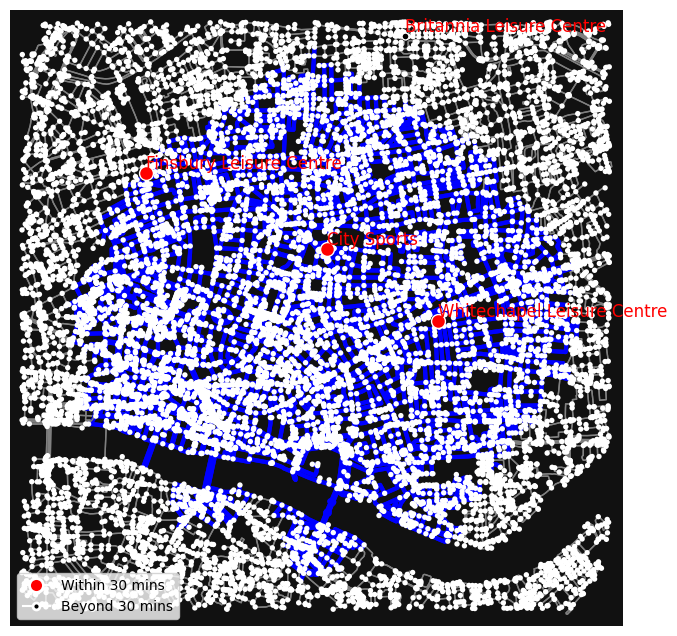

In [26]:
# Calculate the nodes within the reachability area
# Here the nearest node of the apartment location is used as the starting point
apt_node = ox.nearest_nodes(G_walk, apartment_location[1], apartment_location[0])
reachable_nodes = nx.single_source_dijkstra_path_length(G_walk, apt_node, cutoff=max_distance, weight='length')

#Convert nodes within the reachability area to GeoDataFrame
reachable_nodes_gdf = gpd.GeoDataFrame(reachable_nodes.items(), columns=['node', 'time'])
reachable_nodes_gdf = reachable_nodes_gdf.set_index('node').join(gdf_nodes).reset_index()


# Set edge attribute optimization\This part is generated by GPT
# Set edge color
ec = ['blue' if edge[0] in reachable_nodes_gdf['node'].values and edge[1] in reachable_nodes_gdf['node'].values else 'gray' for edge in G_walk.edges()]

# Set edge width
ew = [3 if edge[0] in reachable_nodes_gdf['node'].values and edge[1] in reachable_nodes_gdf['node'].values else 1 for edge in G_walk.edges()]

# Draw the entire network diagram, using different colors and widths to represent the edges within the 30-minute reachable area
fig, ax = ox.plot_graph(G_walk, show=False, close=False, edge_color=ec, edge_linewidth=ew)

# Draw the location of the fitness center
â€‹for center, (lat, lon) in centers.items():
    color = 'red' if centers_nodes[center] in reachable_nodes else 'black'
    size = 100 if centers_nodes[center] in reachable_nodes else 25
    ax.scatter(lon, lat, c=color, s=size, edgecolor='w', zorder=3)
    plt.text(lon, lat, center, fontsize=12, color='red', verticalalignment='bottom')

#Create legend
red_patch = plt.Line2D([0], [0], marker='o', color='w', label='Within 30 mins', markersize=10, markerfacecolor='red', markeredgewidth=2)
black_patch = plt.Line2D([0], [0], marker='o', color='w', label='Beyond 30 mins', markersize=5, markerfacecolor='black', markeredgewidth=2)
plt.legend(handles=[red_patch, black_patch], loc='lower left')

plt.show()
## Reachability analysis results
# Here I have selected four venues where I often go to play badminton. 
# I also walk there. In fact, only Britaania cannot be reached within 30 minutes. 
# This is consistent with the analysis results. 
# However, I often spend 35 minutes walking to Britaania, which is consistent with the analysis. 
# There is a difference in the difference in the picture, considering that my walking speed is faster

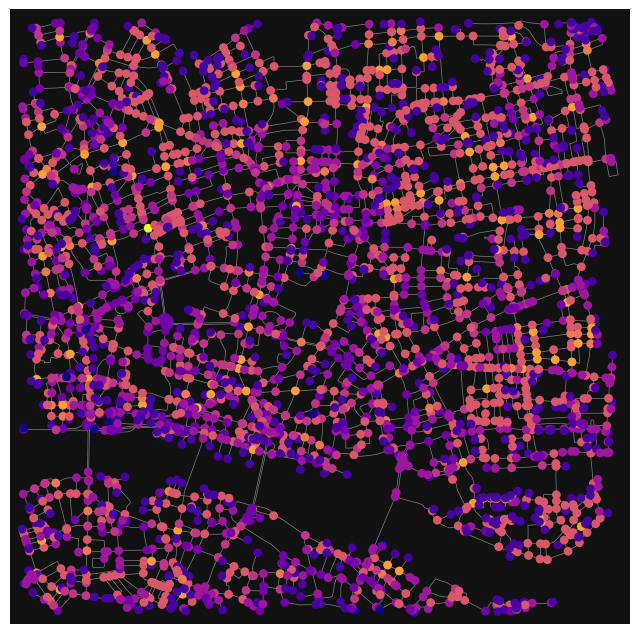

In [27]:
G=ox.graph_from_address('Liverpool Street Station, London', dist=2000, network_type='drive')

# set as diGraph
DG = ox.get_digraph(G)

# calculate node degree centrality
node_dc = nx.degree_centrality(DG)

# set the attributes
nx.set_node_attributes(DG, node_dc,'dc')

# plotting
G1 = nx.MultiGraph(DG)

# color the nodes in the original graph with their degree centralities 
nc = ox.plot.get_node_colors_by_attr(G1, 'dc', cmap='plasma')
fig, ax = ox.plot_graph(G1, node_size=40, node_color=nc, 
                        edge_color='gray', edge_linewidth=0.5, edge_alpha=1)

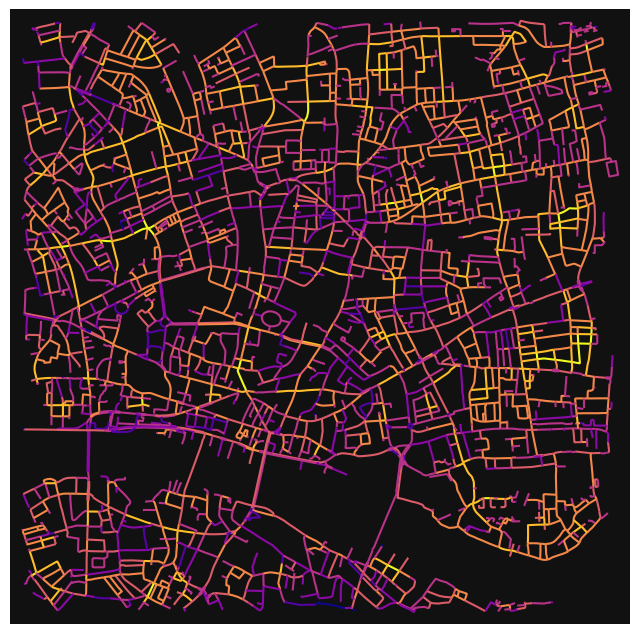

In [28]:
# calculate its edge degree centrality
edge_dc = nx.degree_centrality(nx.line_graph(DG))

# set the attributes
nx.set_edge_attributes(DG, edge_dc,'dc')

# plotting
G1 = nx.MultiGraph(DG)

# color the edges in the original graph with degree centralities in the line graph
nc = ox.plot.get_edge_colors_by_attr(G1, 'dc', cmap='plasma')
fig, ax = ox.plot_graph(G1, node_size=0, node_color='w', node_edgecolor='gray', node_zorder=2,
                        edge_color=nc, edge_linewidth=1.5, edge_alpha=1)

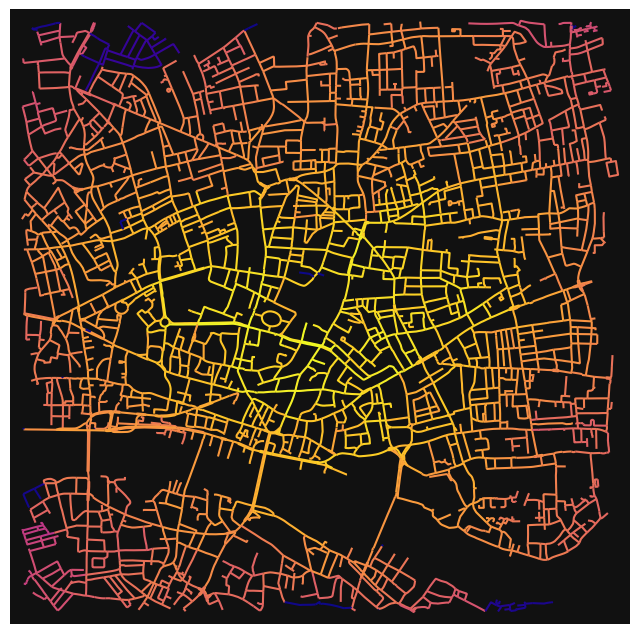

In [29]:
# calculate edge closeness centrality
edge_cc = nx.closeness_centrality(nx.line_graph(DG))

# set or inscribe the centrality measure of each node as an edge attribute of the graph network object
nx.set_edge_attributes(DG,edge_cc,'cc')
G1 = nx.MultiGraph(DG)

# color the edges in the original graph with closeness centrality in the line graph. 
nc = ox.plot.get_edge_colors_by_attr(G1, 'cc', cmap='plasma')
fig, ax = ox.plot_graph(G1, node_size=0, node_color='w', node_edgecolor='gray', node_zorder=2,
                        edge_color=nc, edge_linewidth=1.5, edge_alpha=1)

In [32]:
jupyter nbconvert--to markdown <FormativeCoursework.ipynb>

SyntaxError: invalid syntax (126021522.py, line 1)